# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.351565
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*  
Under probabilistic interpretation, the output of the softmax function inside of logrithm is the 'probability'/'confidence' of correct prediction. As the current setting of the classifier is compeletely random, we should expect the prediction to be a "random guess" from one of the ten classes. The normalised probability of that should be 0.1.

In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.225372 analytic: -0.225372, relative error: 5.648402e-08
numerical: 1.864687 analytic: 1.864687, relative error: 1.980419e-08
numerical: -1.882830 analytic: -1.882830, relative error: 6.592232e-09
numerical: -2.835998 analytic: -2.835998, relative error: 6.031961e-09
numerical: 0.823929 analytic: 0.823929, relative error: 2.743498e-08
numerical: -0.542845 analytic: -0.542845, relative error: 4.224318e-08
numerical: 0.385591 analytic: 0.385591, relative error: 7.427624e-08
numerical: 1.210592 analytic: 1.210592, relative error: 1.642392e-08
numerical: -0.418910 analytic: -0.418910, relative error: 9.166905e-09
numerical: 2.164834 analytic: 2.164834, relative error: 7.289656e-09
numerical: -2.728789 analytic: -2.728789, relative error: 2.276711e-08
numerical: 0.935006 analytic: 0.935006, relative error: 1.429526e-08
numerical: -2.124800 analytic: -2.124800, relative error: 9.094944e-09
numerical: 1.445128 analytic: 1.445128, relative error: 2.117516e-08
numerical: 1.288648 

In [ ]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

In [5]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
import copy
results = {}
best_val = -1  # best validation accuracy 
best_softmax = None

## some control parameters
# choose the number of parameters to try within their respective range
num_lr = 10
num_reg = 10

# number of iterations for Batch GD
# (use a small value when testing the coding, increase to 1500+ for actual training)
# num_iters = 100  # for coding
num_iters = 1500  # for training

# the data set used to train the model
# (use development dataset when testing the coding, swtich to training dataset for actual training)
# train_data_set = (X_dev, y_dev)  # for coding
train_data_set = (X_train,y_train)  # for training


## set the hyper parameters to cross-validate
# original parameter ranges
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

# build a list of paramters
learning_rates = np.linspace(1, 5, num_lr) * 1e-7
regularization_strengths = np.linspace(2.5, 5, num_reg) * 1e4


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# build a function that construct parameter into pairs
def hyperpara_pairs(hyper1, hyper2):
    num_lr = len(hyper1)
    num_reg = len(hyper2)
    hyper_para = np.zeros((num_lr * num_reg, 2))
    idx = 0
    for lr in learning_rates:
        for reg in regularization_strengths:
            hyper_para[idx] = np.array([lr, reg])
            idx += 1
    return hyper_para
    
hyper_pairs = hyperpara_pairs(learning_rates, regularization_strengths)
print('Cross-validating %s pairs of hyperparameters \n' % (str(hyper_pairs.shape[0])))

## beginning of cross-validation
print('Starting cross-validation: \n')
tic = time.time()

softmax = Softmax()  # create an instance of the class: Softmax(object)
for (lr, reg) in hyper_pairs:    
    # train the model
    loss_history = softmax.train(train_data_set[0], train_data_set[1], 
                                 learning_rate=lr, reg=reg, 
                                 num_iters=num_iters, batch_size=200, verbose=False)
    # use model to predict
    training_accuracy = np.mean(softmax.predict(train_data_set[0]) == train_data_set[1])
    validation_accuracy = np.mean(softmax.predict(X_val) == y_val)
    
    # store results
    results[(lr, reg)] = (training_accuracy, validation_accuracy)
    if validation_accuracy > best_val:
        best_val = validation_accuracy
        best_softmax = copy.deepcopy(softmax)  # same as SVM, deep copy to re-create pointer

toc = time.time()
print('Cross-validation completed. Time used: %ssec'% str(toc-tic))

## end of cross-validation

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

Cross-validating 100 pairs of hyperparameters 

Starting cross-validation: 

Cross-validation completed. Time used: 1017.6404249668121sec
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.329286 val accuracy: 0.348000
lr 1.000000e-07 reg 2.777778e+04 train accuracy: 0.331816 val accuracy: 0.337000
lr 1.000000e-07 reg 3.055556e+04 train accuracy: 0.321878 val accuracy: 0.337000
lr 1.000000e-07 reg 3.333333e+04 train accuracy: 0.318898 val accuracy: 0.325000
lr 1.000000e-07 reg 3.611111e+04 train accuracy: 0.324286 val accuracy: 0.332000
lr 1.000000e-07 reg 3.888889e+04 train accuracy: 0.313898 val accuracy: 0.333000
lr 1.000000e-07 reg 4.166667e+04 train accuracy: 0.320469 val accuracy: 0.330000
lr 1.000000e-07 reg 4.444444e+04 train accuracy: 0.314163 val accuracy: 0.325000
lr 1.000000e-07 reg 4.722222e+04 train accuracy: 0.302102 val accuracy: 0.320000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.301816 val accuracy: 0.315000
lr 1.444444e-07 reg 2.500000e+04 train accuracy: 0.3

In [6]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.337000


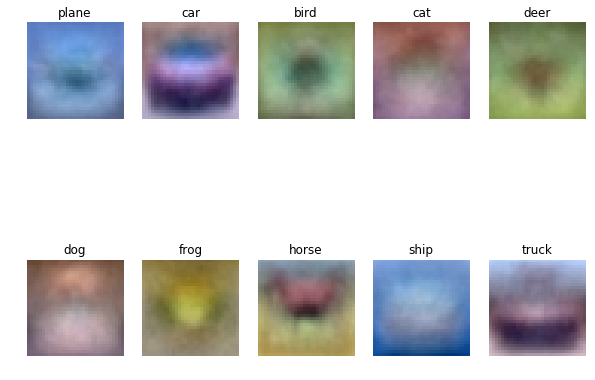

In [7]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])